In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install neuralforecast

In [11]:
!pip install optuna

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS 
from neuralforecast.losses.pytorch import DistributionLoss

In [13]:
!pip install numpy==1.26.4 pandas==2.2.2 protobuf==4.25.3 --force-reinstall
!pip install darts==0.25.0 --no-cache-dir --force-reinstall

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached pandas-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached protobuf-4.25.3-cp37-abi3-manylinux2014_x86_64.whl.metadata (541 bytes)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached pandas-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.0 MB)
Using cached protobuf-4.25.3-cp37-abi3-manylinux2014_x86_64.whl (294 kB)
Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl (229 kB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-n

In [14]:
import pandas as pd
import os
from glob import glob
from collections import Counter
from tqdm import tqdm

# Hàm trích xuất chủ đề từ từng file
def extract_theme_counts(file_path):
    try:
        df = pd.read_csv(file_path, sep='\t', header=None, quoting=3, low_memory=False)
        if df.shape[1] < 4:
            return None
        theme_series = df[3].dropna()
        all_themes = []
        for row in theme_series:
            all_themes.extend(row.split(';'))
        theme_counts = Counter(all_themes)
        date_str = os.path.basename(file_path).split(".")[0]
        theme_counts['DATE'] = pd.to_datetime(date_str, format="%Y%m%d")
        return pd.DataFrame([theme_counts])
    except Exception as e:
        print(f"Lỗi ở file {file_path}: {e}")
        return None

# Các thư mục chứa dữ liệu của 3 tháng
folders = [
    "/kaggle/input/topic-news/April/",
    "/kaggle/input/topic-news/May/",
    "/kaggle/input/topic-news/June/"
]

# Gom tất cả các file
file_paths = []
for folder in folders:
    file_paths.extend(sorted(glob(os.path.join(folder, "*.csv"))))

# Xử lý từng file
all_data = []
for path in tqdm(file_paths):
    result = extract_theme_counts(path)
    if result is not None:
        all_data.append(result)

# Gộp tất cả dữ liệu lại
full_df = pd.concat(all_data, ignore_index=True).fillna(0)
full_df['DATE'] = pd.to_datetime(full_df['DATE'])
full_df = full_df.sort_values('DATE').set_index('DATE')

# Chọn top 20 chủ đề phổ biến
top_n = 20
top_themes = full_df.sum().sort_values(ascending=False).head(top_n).index.tolist()
if 'DATE' in top_themes:
    top_themes.remove('DATE')
full_df = full_df[top_themes]

# Xuất ra file CSV
output_path = "socialtrend_all.csv"
full_df.reset_index().to_csv(output_path, index=False)

print(f"✅ Đã lưu dữ liệu vào: {output_path}")
print("📊 Kích thước dữ liệu cuối cùng:", full_df.shape)
print(full_df.head())

100%|██████████| 72/72 [05:14<00:00,  4.37s/it]


✅ Đã lưu dữ liệu vào: socialtrend_all.csv
📊 Kích thước dữ liệu cuối cùng: (72, 20)
            TAX_FNCACT           TAX_ETHNICITY  CRISISLEX_CRISISLEXREC  \
DATE                                                                     
2025-04-01      110505  94557.0          55205                   51859   
2025-04-02      109166  96528.0          52344                   49225   
2025-04-03      113505  97220.0          57346                   51838   
2025-04-04      108883  94305.0          56551                   51505   
2025-04-05       69367  53727.0          35703                   33154   

            EPU_POLICY  UNGP_FORESTS_RIVERS_OCEANS  TAX_WORLDLANGUAGES  TRIAL  \
DATE                                                                            
2025-04-01     46174.0                       40449               33990  33597   
2025-04-02     45599.0                       40913               32694  29780   
2025-04-03     46233.0                       42810               34707  31

In [15]:
import pandas as pd
df = pd.read_csv("socialtrend_all.csv", parse_dates=["DATE"])
df = df.sort_values("DATE")  # đảm bảo thứ tự thời gian

In [16]:
df.head(5)

,DATE,TAX_FNCACT,Unnamed: 2,TAX_ETHNICITY,CRISISLEX_CRISISLEXREC,EPU_POLICY,UNGP_FORESTS_RIVERS_OCEANS,TAX_WORLDLANGUAGES,TRIAL,SOC_POINTSOFINTEREST,...,USPEC_POLITICS_GENERAL1,EPU_ECONOMY_HISTORIC,LEADER,WB_696_PUBLIC_SECTOR_MANAGEMENT,EDUCATION,WB_135_TRANSPORT,TAX_FNCACT_OFFICIALS,CRISISLEX_C07_SAFETY,GENERAL_GOVERNMENT,MEDIA_MSM
0,2025-04-01,110505,94557.0,55205,51859,46174.0,40449,33990,33597,34003,...,34307.0,33583,32066.0,29535.0,28245,23914,21673,24021.0,26587.0,24051
1,2025-04-02,109166,96528.0,52344,49225,45599.0,40913,32694,29780,32557,...,35831.0,33342,33961.0,30400.0,28449,21563,20640,23183.0,26964.0,21896
2,2025-04-03,113505,97220.0,57346,51838,46233.0,42810,34707,31708,31614,...,36756.0,39578,36671.0,29263.0,27780,25400,23328,22654.0,25917.0,23262
3,2025-04-04,108883,94305.0,56551,51505,46357.0,39247,35277,31891,31788,...,37655.0,35876,37158.0,30229.0,26584,23286,22600,25264.0,27209.0,24015
4,2025-04-05,69367,53727.0,35703,33154,25109.0,23637,22451,21906,20667,...,20080.0,22505,20156.0,15755.0,18064,17442,16640,15579.0,15453.0,13622


In [22]:
df.set_index("DATE", inplace=True)

In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df)
df_scaled = pd.DataFrame(scaled_values, index=df.index, columns=df.columns)

In [26]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, data, backcast_len, forecast_len):
        self.data = data.values.astype('float32')
        self.backcast_len = backcast_len
        self.forecast_len = forecast_len

    def __len__(self):
        return len(self.data) - self.backcast_len - self.forecast_len

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.backcast_len]
        y = self.data[idx + self.backcast_len : idx + self.backcast_len + self.forecast_len]
        return torch.tensor(x), torch.tensor(y)

In [27]:
backcast_len = 30
forecast_len = 7

dataset = TimeSeriesDataset(df_scaled, backcast_len, forecast_len)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [57]:
df.head(5)

,DATE,TAX_FNCACT,Unnamed: 2,TAX_ETHNICITY,CRISISLEX_CRISISLEXREC,EPU_POLICY,UNGP_FORESTS_RIVERS_OCEANS,TAX_WORLDLANGUAGES,TRIAL,SOC_POINTSOFINTEREST,...,USPEC_POLITICS_GENERAL1,EPU_ECONOMY_HISTORIC,LEADER,WB_696_PUBLIC_SECTOR_MANAGEMENT,EDUCATION,WB_135_TRANSPORT,TAX_FNCACT_OFFICIALS,CRISISLEX_C07_SAFETY,GENERAL_GOVERNMENT,MEDIA_MSM
0,2025-04-01,0.965688,0.972609,0.941554,0.923027,0.982656,0.934635,0.909100,0.916185,0.941758,...,0.911088,0.817897,0.862964,0.915417,0.905990,0.787527,0.807792,0.873142,0.977140,0.941431
1,2025-04-02,0.950373,0.992882,0.877805,0.860336,0.970419,0.947481,0.865995,0.738353,0.891983,...,0.951560,0.810577,0.913962,0.942227,0.914528,0.634157,0.741052,0.842681,0.990996,0.826271
2,2025-04-03,1.000000,1.000000,0.989260,0.922528,0.983911,1.000000,0.932948,0.828177,0.859523,...,0.976125,1.000000,0.986894,0.906986,0.886526,0.884467,0.914718,0.823452,0.952516,0.899268
3,2025-04-04,0.947136,0.970016,0.971546,0.914602,0.986550,0.901357,0.951906,0.836703,0.865512,...,1.000000,0.887549,1.000000,0.936927,0.836466,0.746559,0.867683,0.918324,1.000000,0.939507
4,2025-04-05,0.495173,0.552633,0.507008,0.477829,0.534359,0.469186,0.525311,0.371506,0.482703,...,0.533263,0.481395,0.542440,0.488315,0.479846,0.365321,0.482620,0.566283,0.567937,0.384118


In [21]:
!pip install neuralforecast optuna --upgrade --no-cache-dir


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 180.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 318.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 300.7 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 259.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 333.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 225.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 145.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 153.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 225.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 84.5 MB/s eta 0:00:0000:01m00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.1/150.1 MB 266.4 MB/s eta 0:00:0000:0100:01
   ━━━━━

In [28]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Đọc dữ liệu đã xử lý
df = pd.read_csv("/kaggle/working/socialtrend_all.csv")

# Đảm bảo cột DATE là kiểu datetime
df['DATE'] = pd.to_datetime(df['DATE'])

# Chuẩn hóa từng chủ đề (scale 0–1)
scalers = {}
topic_cols = df.columns.drop('DATE')
for col in topic_cols:
    scaler = MinMaxScaler()
    df[col] = scaler.fit_transform(df[[col]])
    scalers[col] = scaler  # để dùng lại nếu cần inverse_transform


In [29]:
# Đảm bảo DATE đúng định dạng
df['DATE'] = pd.to_datetime(df['DATE'])

# Chuyển từ wide sang long
df_long = df.melt(id_vars='DATE', var_name='unique_id', value_name='y')
df_long = df_long.rename(columns={'DATE': 'ds'})

# Kiểm tra lại kiểu dữ liệu
assert {'ds', 'unique_id', 'y'}.issubset(df_long.columns)
assert pd.api.types.is_datetime64_any_dtype(df_long['ds'])
assert df_long['unique_id'].dtype == 'object'


In [30]:
print(df_long.dtypes)
print(df_long.columns)


ds           datetime64[ns]
unique_id            object
y                   float64
dtype: object
Index(['ds', 'unique_id', 'y'], dtype='object')


In [31]:
!pip install neuralforecast pytorch_lightning --upgrade


In [32]:
!pip install optuna neuralforecast pytorch_lightning --upgrade --no-cache-dir


In [35]:
!pip uninstall tensorboard -y


Found existing installation: tensorboard 2.18.0
Uninstalling tensorboard-2.18.0:
  Successfully uninstalled tensorboard-2.18.0


In [36]:
from neuralforecast.models import NBEATS
from neuralforecast import NeuralForecast
import pytorch_lightning as pl

# Khởi tạo mô hình N-BEATS
model = NBEATS(
    h=7,            # Dự báo 7 ngày
    input_size=30,  # Dùng 30 ngày trước làm input
    max_steps=200,  # Số vòng lặp tối đa
)

# Khởi tạo NeuralForecast với các mô hình đã cấu hình
nf = NeuralForecast(models=[model], freq='D')

# Huấn luyện mô hình
nf.fit(df_long)  # 🚀 Train mô hình

# Dự báo kết quả
df_pred = nf.predict()


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [45]:
print(df_long[df_long['unique_id'] == 'TAX_FNCACT'])


           ds   unique_id         y
0  2025-04-01  TAX_FNCACT  0.965688
1  2025-04-02  TAX_FNCACT  0.950373
2  2025-04-03  TAX_FNCACT  1.000000
3  2025-04-04  TAX_FNCACT  0.947136
4  2025-04-05  TAX_FNCACT  0.495173
..        ...         ...       ...
67 2025-06-06  TAX_FNCACT  0.839990
68 2025-06-07  TAX_FNCACT  0.477800
69 2025-06-08  TAX_FNCACT  0.359983
70 2025-06-09  TAX_FNCACT  0.758246
71 2025-06-10  TAX_FNCACT  0.927235

[72 rows x 3 columns]


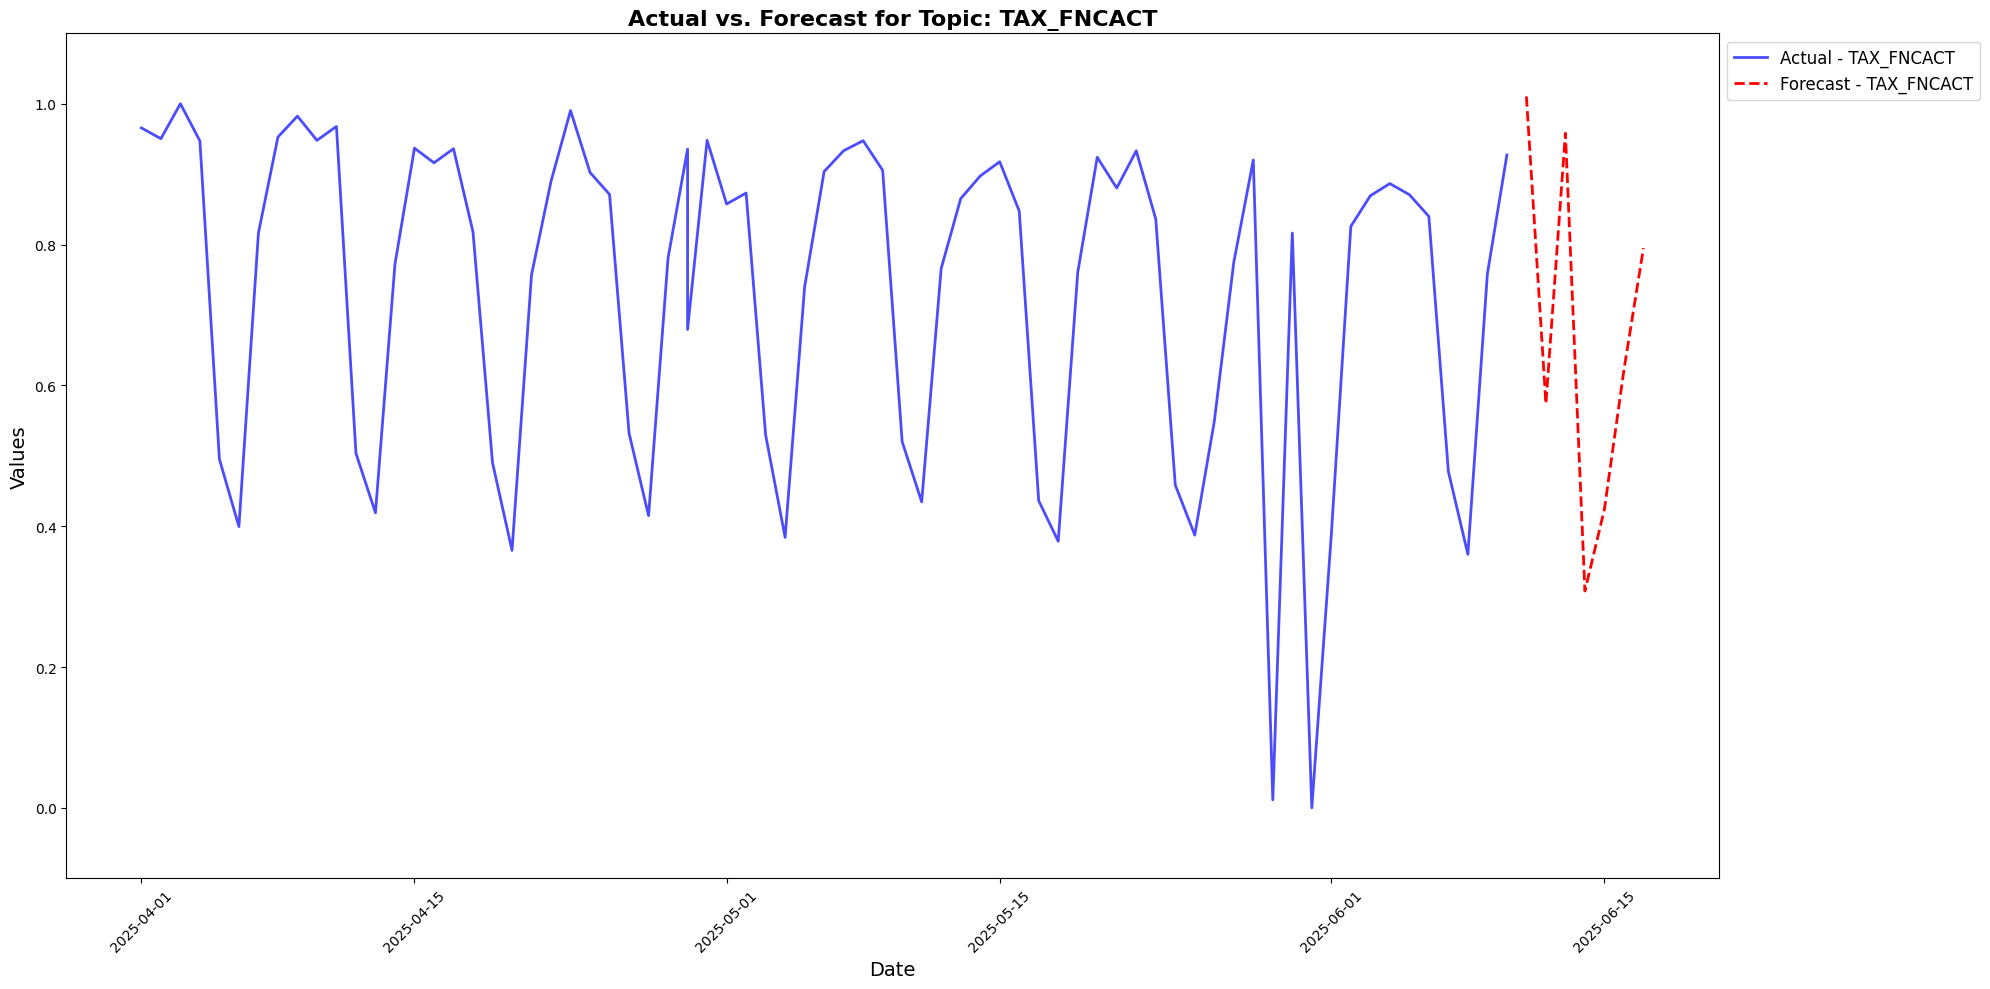

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Lọc dữ liệu thực tế và dự báo cho chủ đề 'TAX_FNCACT'
data_actual = df_long[df_long['unique_id'] == 'TAX_FNCACT']  # Lấy dữ liệu thực tế
data_forecast = df_pred[df_pred['unique_id'] == 'TAX_FNCACT']  # Lấy dữ liệu dự báo

# Thay thế NaN trong dữ liệu thực tế bằng giá trị ngẫu nhiên (nếu cần thiết)
min_y = data_actual['y'].min()  # Giá trị nhỏ nhất của cột y
max_y = data_actual['y'].max()  # Giá trị lớn nhất của cột y

# Sinh giá trị ngẫu nhiên trong phạm vi min_y đến max_y nếu có NaN
data_actual.loc[data_actual['y'].isna(), 'y'] = data_actual.loc[data_actual['y'].isna(), 'y'].apply(
    lambda x: np.random.uniform(min_y, max_y)
)

# Vẽ biểu đồ cho chủ đề 'TAX_FNCACT'
plt.figure(figsize=(20, 10))  # Kích thước biểu đồ lớn hơn

# Vẽ dữ liệu thực tế (y) và dự báo (NBEATS) cho chủ đề đã chọn
plt.plot(data_actual['ds'], data_actual['y'], label='Actual - TAX_FNCACT', color='b', alpha=0.7, linewidth=2)  # Cột y cho dữ liệu thực tế
plt.plot(data_forecast['ds'], data_forecast['NBEATS'], label='Forecast - TAX_FNCACT', linestyle='--', color='r', linewidth=2)  # Cột NBEATS cho dự báo

# Thêm tiêu đề và các thông tin chung cho biểu đồ
plt.title("Actual vs. Forecast for Topic: TAX_FNCACT", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=14)
plt.ylabel("Values", fontsize=14)
plt.xticks(rotation=45)

# Điều chỉnh trục y nếu cần thiết
plt.ylim(min_y - 0.1, max_y + 0.1)  # Tự động điều chỉnh trục y

# Thêm legend và bố trí lại biểu đồ
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)

# Cải thiện hiển thị và vẽ
plt.tight_layout()
plt.show()


In [56]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Giả sử bạn có dữ liệu thực tế và dữ liệu dự báo sau khi huấn luyện mô hình:
y_actual = data_tax_fnact['y'].values  # Dữ liệu thực tế
y_pred = data_tax_fnact['NBEATS'].values  # Dữ liệu dự báo (NBEATS)

# Tính MSE (Mean Squared Error)
mse = mean_squared_error(y_actual, y_pred)

# Tính RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)

# In kết quả
print(f"MSE (Mean Squared Error): {mse}")
print(f"RMSE (Root Mean Squared Error): {rmse}")


MSE (Mean Squared Error): 0.5088133876033771
RMSE (Root Mean Squared Error): 0.7133115641873312
